# Predicting the Future

# Predicting unknow case - treated HDPE + SWCNT

### What happens if we want to predict composite we do not have data before?

We know `treated HDPE` with MWCNT and GNP

But we do not have data with SWCNT

If we force Model to predict, what would we have?

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Import this module's functions
from functions import (
    SuperHighVariationScaler,
    map_num_to_string,
    map_string_to_num,
    sparse_array,
)

## Import data

In [2]:
# Load all data
file_name_all_data = "data/_nanocomposite_data.csv"
all_data = pd.read_csv(file_name_all_data, index_col=None, header=0)
all_data_clean = all_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)
# Load unknown data
file_name_unknown_data = "data-evaluation/HDPEtreated_SWCNT_data-set-6.csv"
unknown_data = pd.read_csv(file_name_unknown_data, index_col=None, header=0)
unknown_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
    inplace=True,
)
unknown_data.head()

,polymer_1,filler_1,wt_l1,conductivity
0,HDPEtreated,SWCNT,2.785803,NaN
1,HDPEtreated,SWCNT,4.828533,NaN
2,HDPEtreated,SWCNT,3.791079,NaN
3,HDPEtreated,SWCNT,23.730889,NaN
4,HDPEtreated,SWCNT,0.613343,NaN


## Loading saved data

Loading saved model and scalers

In [3]:
from pickle import load

# Load model
model = tf.keras.models.load_model('saved/predictor-conductivity-model')

# Load scalers
X_scaler = load(open('saved/X_scaler.pkl', 'rb'))
Y_scaler = load(open('saved/Y_scaler.pkl', 'rb'))

In [4]:
unknown_data_clean = unknown_data.copy()
unknown_data_clean = map_string_to_num(unknown_data_clean)
unknown_data_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,1,1,2.785803,NaN
1,1,1,4.828533,NaN
2,1,1,3.791079,NaN
3,1,1,23.730889,NaN
4,1,1,0.613343,NaN


In [5]:
# Pull out columns for X (data to predict)
X_unknown_data = unknown_data_clean.drop('conductivity', axis=1).values
X_scaled_unknown_data = X_scaler.transform(X_unknown_data)

In [6]:
# Calculate predictions
predicted_unknown_data = model.predict(X_scaled_unknown_data)
predicted_unknown_data = Y_scaler.inverse_transform(predicted_unknown_data)

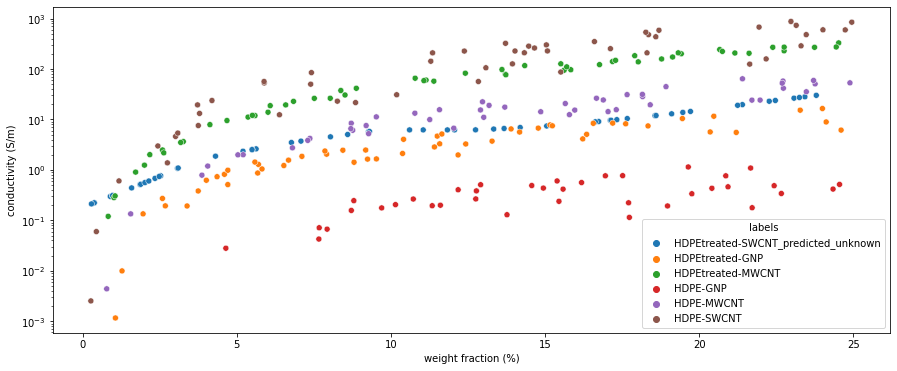

In [7]:
complete_data = unknown_data.copy()
complete_data["labels"] = (
    complete_data["polymer_1"]
    + "-"
    + complete_data["filler_1"]
    + "_predicted_unknown"
)
complete_data["conductivity"] = predicted_unknown_data

all_data["labels"] = all_data["polymer_1"] + "-" + all_data["filler_1"]

complete_data = pd.concat([complete_data, all_data.copy()], ignore_index=True)

# reduce data rows to 5% (sparse data)
complete_data_subset = sparse_array(complete_data, 0.95)

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
g = sns.scatterplot(
    data=complete_data_subset, x="wt_l1", y="conductivity", hue="labels", ax=ax
)

# Conclusion

## Average prediction

We would expect the treated HDPE/SWCNT has higher conductivity. However, the prediction shows the average in conductivity. The issues might due to the fact that there is a lack of other combinations of polymer and filler, especially for SWCNT where there is only one dataset of SWCNT input to train the model.

## Good point

At the very low end, the prediction shows that the treated HDPE/SWCNT has higher conductivity than the rest which is expected for treated polymer.

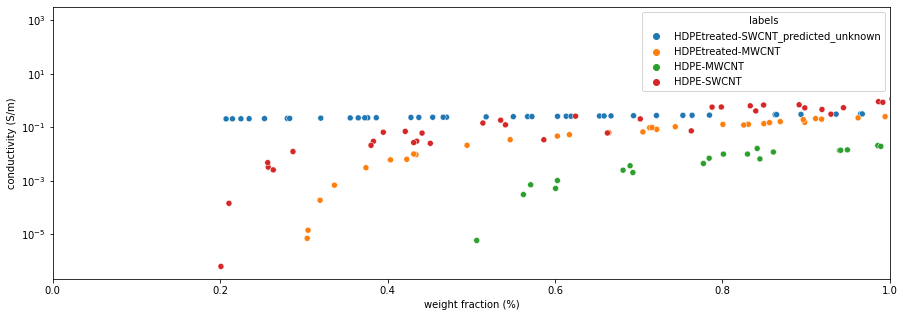

In [8]:
complete_data = unknown_data.copy()
complete_data["labels"] = (
    complete_data["polymer_1"]
    + "-"
    + complete_data["filler_1"]
    + "_predicted_unknown"
)
complete_data["conductivity"] = predicted_unknown_data

all_data["labels"] = all_data["polymer_1"] + "-" + all_data["filler_1"]
other_data = all_data[all_data["filler_1"] != "GNP"].copy()

complete_data = pd.concat([complete_data, other_data], ignore_index=True)

fig_dims = (15, 5)
fig, ax = plt.subplots(figsize=fig_dims)
plt.xlabel("weight fraction (%)")
plt.ylabel("conductivity (S/m)")
plt.yscale("log")
plt.xlim([0, 1])
g = sns.scatterplot(
    data=complete_data, x="wt_l1", y="conductivity", hue="labels", ax=ax
)